![alt text](awesome_logo.png "Awesome Retirement Portfolio Projector Tool")

# My Portfolio

In [344]:
# For data management
import sqlalchemy as sql
import pandas as pd
import os
import datetime
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv

#For Portfolo Optimization
import numpy as np
import pandas as pd
import hvplot.pandas  
from scipy.optimize import minimize, Bounds

#For Simulation
from MCForecastTools import MCSimulation

load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

Python-dotenv could not parse statement starting at line 1


In [345]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [346]:
# Get porfolio and report data from user
connection_string = 'sqlite:///awesome_app.db'
engine = sql.create_engine(connection_string, echo=False)

portfolio_df = pd.read_sql_query("SELECT * FROM portfolio", engine)

report_df = pd.read_sql_query("SELECT * FROM report", engine)
[risk_tolerance, years_until_retirement] = report_df.iloc[0]

portfolio_df

,symbol,quantity,type
0,GOOG,10.0,Equity
1,CMG,20.0,Equity
2,IBM,50.0,Equity
3,XLB,100.0,Equity


In [347]:
print(f"My risk level is {risk_tolerance}.")
print(f"I plan on retiring in {years_until_retirement} years.")

My risk level is high.
I plan on retiring in 20.0 years.


In [348]:
#CHANGE IN INITIAL POSITION
new_quantities=pd.DataFrame({'quantity':[10,20,500,1000]})
new_quantities
portfolio_df.update(new_quantities)
portfolio_df


,symbol,quantity,type
0,GOOG,10.0,Equity
1,CMG,20.0,Equity
2,IBM,500.0,Equity
3,XLB,1000.0,Equity


In [349]:
#ADDED PAOLA
# Tickers for portfolio and recommendation
etf_addition_for_diversification=pd.DataFrame([{"symbol":"SPY", "quantity":0, "type":"Equity"},{"symbol":"AGG", "quantity":0, "type":"Fixed Income"}])
etf_addition_for_diversification

,symbol,quantity,type
0,SPY,0,Equity
1,AGG,0,Fixed Income


In [350]:
#ADDED PAOLA
# Portfolio extended for recommendation based on risk profile
portfolio_extended_df=pd.concat([portfolio_df, etf_addition_for_diversification], axis=0)
portfolio_extended_df["Equity"]=portfolio_extended_df["type"]=="Equity"
portfolio_extended_df=portfolio_extended_df.sort_values("symbol",ignore_index=True)
portfolio_extended_df

,symbol,quantity,type,Equity
0,AGG,0.0,Fixed Income,False
1,CMG,20.0,Equity,True
2,GOOG,10.0,Equity,True
3,IBM,500.0,Equity,True
4,SPY,0.0,Equity,True
5,XLB,1000.0,Equity,True


In [351]:
#ADDED PAOLA
# Tickers preparation for ALPACA
tickers=portfolio_extended_df["symbol"]
tickers=tickers.drop_duplicates()
tickers

0     AGG
1     CMG
2    GOOG
3     IBM
4     SPY
5     XLB
Name: symbol, dtype: object

In [352]:
# Set the tickers
#tickers = portfolio_df["symbol"]

# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"
# Set the number of years of data to fetch
num_years = 30

# Fetch batches of data from alpaca api to get as miuch hostorical data as possible (up to num_years)
batch_size = 1000
num_days_data_needed = num_years * 365
first_date = datetime.datetime.now()
last_date = first_date - datetime.timedelta(days=num_days_data_needed)

def format_date_iso(date):
    return pd.Timestamp(date, tz="America/New_York").isoformat()

# empty DF to hold alpaca data
all_results_df = pd.DataFrame()


next_batch_date = first_date
while num_days_data_needed > 0:
    end_date = str(next_batch_date).split()[0]
    
    next_batch_date -= datetime.timedelta(days=batch_size)
    if next_batch_date < last_date:
        next_batch_date = last_date

    start_date = str(next_batch_date).split()[0]
    
    results_batch_df = alpaca.get_barset(
        tickers,
        timeframe,
        start = format_date_iso(start_date),
        end = format_date_iso(end_date),
        limit = batch_size
    ).df
    
    results_batch_df.drop(['open', 'high', 'low', 'volume'], level=1, axis=1, inplace=True)

    all_results_df = pd.concat([all_results_df, results_batch_df])
    num_days_data_needed -= batch_size

all_results_df.sort_index(inplace=True)

# Display data
all_results_df

,AGG,CMG,GOOG,IBM,SPY,XLB
,close,close,close,close,close,close
time,,,,,,
2008-01-02 00:00:00-05:00,101.65,146.68,342.59,104.79,144.55,41.33
2008-01-03 00:00:00-05:00,101.72,141.46,342.49,104.94,144.46,41.80
2008-01-04 00:00:00-05:00,102.12,127.12,328.48,101.11,140.93,40.74
2008-01-07 00:00:00-05:00,102.26,123.61,324.34,100.14,141.46,40.25
2008-01-08 00:00:00-05:00,102.51,117.77,315.66,97.39,138.81,39.60
...,...,...,...,...,...,...
2021-08-10 00:00:00-04:00,115.44,1866.79,2763.32,141.41,442.66,85.31
2021-08-11 00:00:00-04:00,115.55,1856.10,2752.99,142.15,443.74,86.52


In [353]:
# ORIGINAL PORTFOLIO
last_price = []
for t in portfolio_df['symbol']:
    last_price.append(all_results_df[t]['close'][-1])

portfolio_df['price'] = last_price
portfolio_df['total'] = portfolio_df['price'] * portfolio_df['quantity']
total_portfolio_value = portfolio_df['total'].sum()

display(portfolio_df)
print(f"Total portfolio valus is ${total_portfolio_value:,.2f}")

,symbol,quantity,type,price,total
0,GOOG,10.0,Equity,2778.67,27786.7
1,CMG,20.0,Equity,1877.26,37545.2
2,IBM,500.0,Equity,143.58,71790.0
3,XLB,1000.0,Equity,86.02,86020.0


Total portfolio valus is $223,141.90


In [354]:
# ADDED PAOLA -- THIS FUNCTION WE CAN SET APART AND REUSED TO VALUE PORTFOLIOS
# Extended portfolio
last_price = []
for t in portfolio_extended_df['symbol']:
    last_price.append(all_results_df[t]['close'][-1])

portfolio_extended_df['price'] = last_price
portfolio_extended_df['total'] = portfolio_extended_df['price'] * portfolio_extended_df['quantity']
total_portfolio_extended_value = portfolio_extended_df['total'].sum()

display(portfolio_extended_df)
print(f"Total portfolio valus is ${total_portfolio_extended_value:,.2f}")


,symbol,quantity,type,Equity,price,total
0,AGG,0.0,Fixed Income,False,116.03,0.0
1,CMG,20.0,Equity,True,1877.26,37545.2
2,GOOG,10.0,Equity,True,2778.67,27786.7
3,IBM,500.0,Equity,True,143.58,71790.0
4,SPY,0.0,Equity,True,447.02,0.0
5,XLB,1000.0,Equity,True,86.02,86020.0


Total portfolio valus is $223,141.90


<AxesSubplot:xlabel='time'>

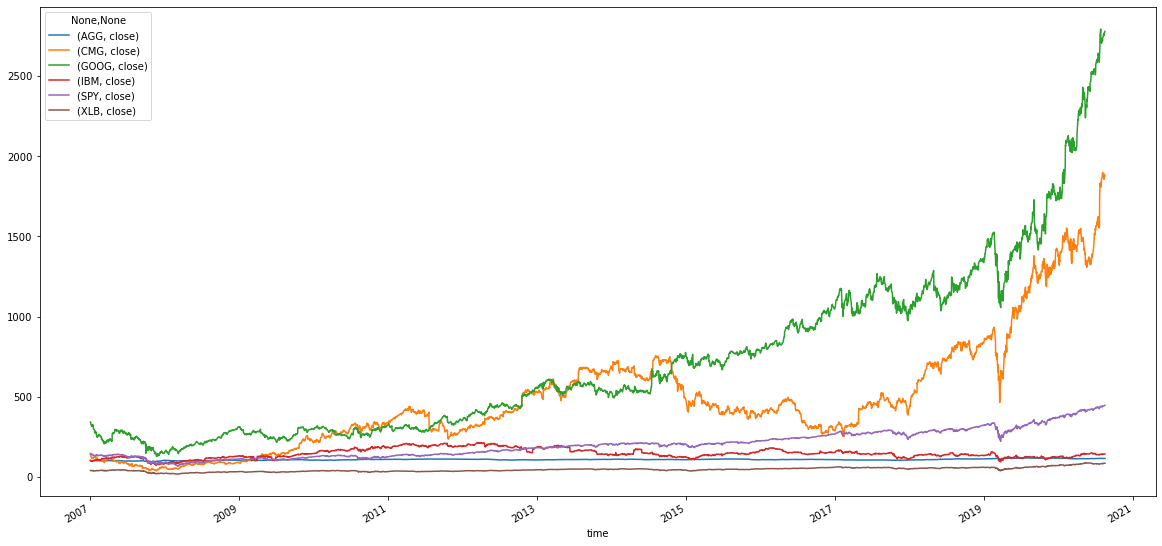

In [355]:
all_close_df = all_results_df.xs('close', axis=1, level=1, drop_level=False)
all_close_df.plot(figsize=[20, 10])

In [356]:
print("Current portfolio expected return")
print("Current portfolio volatility")
print("Current portfolio sharpe ratio")

Current portfolio expected return
Current portfolio volatility
Current portfolio sharpe ratio


---

# Portfolio Optimization - 
Based on https://examples.pyviz.org/portfolio_optimizer/portfolio.html#portfolio-optimizer-gallery-portfolio

Optimizes the Sharpe Ratio of a portfolio based on the risk profile of the user.
1. Import data
2. Calculate log returns and performance measurements associated
3. Determine constraints based on risk assesment
4. Optimizes portfolio for optimal asset allocation to maximize sharpe ratio

In [357]:
portfolio_prices = all_results_df

In [358]:
portfolio_prices.head()

,AGG,CMG,GOOG,IBM,SPY,XLB
,close,close,close,close,close,close
time,,,,,,
2008-01-02 00:00:00-05:00,101.65,146.68,342.59,104.79,144.55,41.33
2008-01-03 00:00:00-05:00,101.72,141.46,342.49,104.94,144.46,41.80
2008-01-04 00:00:00-05:00,102.12,127.12,328.48,101.11,140.93,40.74
2008-01-07 00:00:00-05:00,102.26,123.61,324.34,100.14,141.46,40.25
2008-01-08 00:00:00-05:00,102.51,117.77,315.66,97.39,138.81,39.60


In [359]:
portfolio_daily_returns = portfolio_prices.pct_change(1).dropna()
portfolio_daily_returns.columns = portfolio_daily_returns.columns.droplevel(1)
portfolio_daily_returns.head()

,AGG,CMG,GOOG,IBM,SPY,XLB
time,,,,,,
2008-01-03 00:00:00-05:00,0.000689,-0.035588,-0.000292,0.001431,-0.000623,0.011372
2008-01-04 00:00:00-05:00,0.003932,-0.101371,-0.040906,-0.036497,-0.024436,-0.025359
2008-01-07 00:00:00-05:00,0.001371,-0.027612,-0.012604,-0.009594,0.003761,-0.012027
2008-01-08 00:00:00-05:00,0.002445,-0.047245,-0.026762,-0.027462,-0.018733,-0.016149
2008-01-09 00:00:00-05:00,-0.002927,0.007897,0.033866,0.009652,0.014192,0.009343


In [360]:
# Calculates correlation of securities in the client_portfolio_prices
portfolio_prices.pct_change(1).corr()

,,AGG,CMG,GOOG,IBM,SPY,XLB
,,close,close,close,close,close,close
AGG,close,1.000000,-0.006267,-0.023485,-0.040183,-0.081635,-0.083776
CMG,close,-0.006267,1.000000,0.353559,0.224036,0.460013,0.400047
GOOG,close,-0.023485,0.353559,1.000000,0.341196,0.618315,0.515108
IBM,close,-0.040183,0.224036,0.341196,1.000000,0.564490,0.507721
SPY,close,-0.081635,0.460013,0.618315,0.564490,1.000000,0.886949
XLB,close,-0.083776,0.400047,0.515108,0.507721,0.886949,1.000000


## Switching to log returns

We will switch over to using log returns instead of arithmetic returns, because they are more normal distributed.
Log returns are similar to regular returns for small values, but reduce the size of outliers.

For a full analysis of why we use log returns, check [this article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).


In [361]:
log_daily_returns = np.log(portfolio_prices/portfolio_prices.shift(1)).dropna()
log_daily_returns.columns=log_daily_returns.columns.droplevel(1)
log_daily_returns.head()

,AGG,CMG,GOOG,IBM,SPY,XLB
time,,,,,,
2008-01-03 00:00:00-05:00,0.000688,-0.036236,-0.000292,0.001430,-0.000623,0.011308
2008-01-04 00:00:00-05:00,0.003925,-0.106885,-0.041767,-0.037180,-0.024739,-0.025686
2008-01-07 00:00:00-05:00,0.001370,-0.028000,-0.012684,-0.009640,0.003754,-0.012100
2008-01-08 00:00:00-05:00,0.002442,-0.048398,-0.027127,-0.027846,-0.018911,-0.016281
2008-01-09 00:00:00-05:00,-0.002931,0.007866,0.033305,0.009606,0.014092,0.009300


In [362]:
log_daily_returns.describe().T

,count,mean,std,min,25%,50%,75%,max
AGG,3398.0,0.000036,0.003294,-0.067000,-0.001305,0.000180,0.001496,0.035204
CMG,3398.0,0.000745,0.024837,-0.241135,-0.010120,0.000795,0.011346,0.219169
GOOG,3398.0,0.000663,0.019817,-0.274102,-0.007036,0.000651,0.009212,0.329356
IBM,3398.0,0.000160,0.018340,-0.220587,-0.006511,0.000451,0.007315,0.221127
SPY,3398.0,0.000338,0.012960,-0.123683,-0.003945,0.000638,0.005822,0.108826
XLB,3398.0,0.000220,0.016010,-0.122246,-0.006511,0.000834,0.008105,0.111130


In [363]:
# Annualized returns
log_daily_returns.mean() * 252

AGG     0.009096
CMG     0.187713
GOOG    0.167011
IBM     0.040420
SPY     0.085156
XLB     0.055368
dtype: float64

In [364]:
# Compute daily covariance matrix
log_daily_returns.cov()

,AGG,CMG,GOOG,IBM,SPY,XLB
AGG,1.085072e-05,-4.923681e-07,-0.000002,-0.000003,-0.000003,-0.000004
CMG,-4.923681e-07,6.168727e-04,0.000175,0.000105,0.000148,0.000159
GOOG,-1.531815e-06,1.749146e-04,0.000393,0.000130,0.000162,0.000168
IBM,-2.529548e-06,1.047720e-04,0.000130,0.000336,0.000138,0.000153
SPY,-3.481874e-06,1.478072e-04,0.000162,0.000138,0.000168,0.000184
XLB,-4.426013e-06,1.588997e-04,0.000168,0.000153,0.000184,0.000256


In [365]:
# Annualized covariance matrix by multiplying by trading days in a year
log_daily_returns.cov()*252 

,AGG,CMG,GOOG,IBM,SPY,XLB
AGG,0.002734,-0.000124,-0.000386,-0.000637,-0.000877,-0.001115
CMG,-0.000124,0.155452,0.044078,0.026403,0.037247,0.040043
GOOG,-0.000386,0.044078,0.098962,0.032727,0.040803,0.042339
IBM,-0.000637,0.026403,0.032727,0.084762,0.034751,0.038616
SPY,-0.000877,0.037247,0.040803,0.034751,0.042329,0.046431
XLB,-0.001115,0.040043,0.042339,0.038616,0.046431,0.064591


# Portfolio Optimization and Recommendation
Level of risk:
1. Aggressive 
2. Moderate
3. Conservative


In [366]:
# set level of risk according to risk profile
level_of_risk=1

In [367]:
#Number of instruments and asset classes
n=len(portfolio_prices.columns)
portfolio_extended_df=portfolio_extended_df.set_index('symbol')

In [368]:
asset_class_securities=pd.DataFrame({"Equity": np.nan, "Fixed Income":np.nan }, index=portfolio_extended_df.index)
asset_class_securities['Equity']=portfolio_extended_df["Equity"]
asset_class_securities

,Equity,Fixed Income
symbol,,
AGG,False,NaN
CMG,True,NaN
GOOG,True,NaN
IBM,True,NaN
SPY,True,NaN
XLB,True,NaN


### Functionalize Return and SR operations

In [369]:
def get_annual_expected_return_volatility_and_sharpe_ratio(portfolio_weights):
    """
    Takes in portfolio_weights, returns array or annualized expected return, volatility, sharpe ratio
    """
    portfolio_weights = np.array(portfolio_weights)
    
    #Annual expected return by the weighted average of daily log returns historical average of each security, multiplied by 252
    expected_annual_return = np.sum(log_daily_returns.mean() * portfolio_weights) * 252
    
    # Annual Portfolio Variance = w.T * Covariance * w    (where "*" represents here the matrix multiplication) OBS: Var_annual = Var_daily * 252
    # np.dot function does a matrix multiplication. Another alternative is np.matmul
    portfolio_variance = np.dot(    portfolio_weights.T,     np.dot(   log_daily_returns.cov() * 252, portfolio_weights   ))
    portfolio_volatility = np.sqrt(portfolio_variance)

    #Sharpe Ratio (annual) (Assumed risk_free_rate=0)
    risk_free_rate_annualized=0
    sharpe_ratio = (expected_annual_return - risk_free_rate_annualized)/portfolio_volatility
    
    return np.array([expected_annual_return,portfolio_volatility,sharpe_ratio]) 

To fully understand all the parameters, check out:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [65]:
#help(minimize)

Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)

In [370]:
# Function to be optimized 
def negative_sharpe_ratio(portfolio_weights):
    return  get_annual_expected_return_volatility_and_sharpe_ratio(portfolio_weights)[2] * -1

In [371]:
# Required arguments for optimization constaints
if level_of_risk==1:
    [equity_lower_limit, equity_upper_limit]  =[0.75, 0.90]

elif level_of_risk==2:
    [equity_lower_limit, equity_upper_limit]  =[0.4, 0.6]

elif level_of_risk==3:
    [equity_lower_limit, equity_upper_limit]  =[0.05 , 0.2]

else: [equity_lower_limit, equity_upper_limit]=[0 , 1]


In [372]:
# Contraints: weight sum must be equal to 1 
def check_sum_of_portfolio_weights_is_one(portfolio_weights):
    '''
    Returns 0 if sum of portfolio_weights is 1.0
    '''
    return np.sum(portfolio_weights) - 1

In [373]:
# Constraint: equity allocation is less than maximum limit (inequality constraint, upper limit - equity allocation >0)
def check_sum_of_portfolio_equity_weights_is_less_than_upper_bound(portfolio_weights, asset_class_securities, equity_upper_limit):
    """
    Makes sure allocation in equity is less than the maximum allowed
    """
    portfolio_equity_allocation=sum(portfolio_weights * asset_class_securities['Equity'])
    return  equity_upper_limit - portfolio_equity_allocation

In [374]:
# Constraint: equity allocation is more than minimum limit (inequality constraint, equity allocation - lower_limit >0)
def check_sum_of_portfolio_equity_weights_is_more_than_lower_bound(portfolio_weights,asset_class_securities , equity_lower_limit):
    """
    Makes sure allocation in equity is more than the minimum allowed
    """
    portfolio_equity_allocation=sum(portfolio_weights * asset_class_securities['Equity'])
    return portfolio_equity_allocation - equity_lower_limit

In [375]:
# By convention of minimize function it should be a function that returns zero for constraints. 
# Constraint type: 'eq' for equality, 'ineq' for inequality. 
# 'fun': The function defining the constraint: sum(portfolio_weights)=1  ==> sum(portfolio_weights) - 1 = 0
#                                                                       upper limit - equity allocation >0
#                                                                       equity allocation - lower_limit >0

cons = [{'type':'eq','fun'  :check_sum_of_portfolio_weights_is_one},
        {'type':'ineq','fun':check_sum_of_portfolio_equity_weights_is_less_than_upper_bound,'args':(asset_class_securities, equity_upper_limit)},
        {'type':'ineq','fun':check_sum_of_portfolio_equity_weights_is_more_than_lower_bound,'args':(asset_class_securities, equity_lower_limit)}]

In [376]:
# Setting bounds for the weights of each security
lb=[0]*n
ub=[1]*n
        
bounds=Bounds(lb, ub)
bounds

Bounds([0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1])

In [377]:
# Initial Guess (equal distribution)
# n: number of stocks in the portfolio to optimize
initial_guess = [1/n]*n
initial_guess

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666]

In [378]:
# Sequential Least SQuares Programming (SLSQP) - Similar to Least Square optimization, but it uses less resources. Approximate using paraboles.
optimization_results = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [379]:
# Optimization results
optimization_results

     fun: -0.6238868621035532
     jac: array([-0.03698179,  0.01333499,  0.01172382,  0.12925222,  0.01177039,
        0.175575  ])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.25      , 0.27907625, 0.43808218, 0.        , 0.03284157,
       0.        ])

In [331]:
# Optimal weights
optimal_portfolio_weights = optimization_results.x

portfolio_position_names=pd.Series(log_daily_returns.columns)
#print(f"portfolio_position_names: {portfolio_position_names}")

optimal_portfolio_weights=pd.Series(optimal_portfolio_weights)

optimal_portfolio_weights=pd.concat([portfolio_position_names,optimal_portfolio_weights], axis=1)
optimal_portfolio_weights=optimal_portfolio_weights.set_index(0)
round(optimal_portfolio_weights,4)

,1
0,
AGG,0.2500
CMG,0.2702
GOOG,0.3976
IBM,0.0000
SPY,0.0823
XLB,0.0000


In [380]:
# Results considering log returns. We will use Abiys with regular returns in presentation.
# Optimal values (Max Sharpe ratio point)
[optimal_expected_return, optimal_volatility, maximum_Sharpe_ratio]= get_annual_expected_return_volatility_and_sharpe_ratio(optimization_results.x)

print( f"Optimal Annual Expected Return: {100*optimal_expected_return:.2f}%"  )
print( f"Optimal Annual Volatility:      {100*optimal_volatility:.2f}%") 
print( f"Maximum Annual Sharpe ratio:    {maximum_Sharpe_ratio:.2f}")


Optimal Annual Expected Return: 13.06%
Optimal Annual Volatility:      20.94%
Maximum Annual Sharpe ratio:    0.62


In [386]:
# Return of results (considering Log returns) We will use Abiys with regular returns in presentation.
# ORIGINAL PORTFOLIO
portfolio_extended_df['allocation'] = portfolio_extended_df['total'].fillna(0)/portfolio_df['total'].sum()
portfolio_extended_df['allocation'] 
np.array(portfolio_extended_df['allocation'])

[original_expected_return, original_volatility, original_Sharpe_ratio]=get_annual_expected_return_volatility_and_sharpe_ratio(np.array(portfolio_extended_df['allocation']))

print( f"Original Annual Expected Return:  {100*original_expected_return:.2f} %"  )
print( f"Original Annual Volatility:       {100*original_volatility:.2f} % ") 
print( f"Original Annual Sharpe ratio:     {original_Sharpe_ratio:.2f}")
round(portfolio_extended_df,2)

Original Annual Expected Return:  8.67 %
Original Annual Volatility:       22.47 % 
Original Annual Sharpe ratio:     0.39


,quantity,type,Equity,price,total,allocation
symbol,,,,,,
AGG,0.0,Fixed Income,False,116.03,0.0,0.00
CMG,20.0,Equity,True,1877.26,37545.2,0.17
GOOG,10.0,Equity,True,2778.67,27786.7,0.12
IBM,500.0,Equity,True,143.58,71790.0,0.32
SPY,0.0,Equity,True,447.02,0.0,0.00
XLB,1000.0,Equity,True,86.02,86020.0,0.39


# MONTECARLO SIMULATION

In [382]:
report_df

,risk_tolerance,years_until_retirement
0,high,20.0


In [383]:
portfolio_extended_df['allocation']

symbol
AGG     0.000000
CMG     0.168257
GOOG    0.124525
IBM     0.321724
SPY     0.000000
XLB     0.385495
Name: allocation, dtype: float64

In [384]:
MC_n_years_new_allocation_original=MCSimulation(
    portfolio_data=all_results_df
    ,weights=list(portfolio_extended_df['allocation'])
    ,num_simulation=500
    ,num_trading_days=252*int(report_df['years_until_retirement'][0])
)

In [224]:
MC_n_years_new_allocation_original.portfolio_data.head()

AGG                  CMG                 GOOG  \
                            close daily_return   close daily_return   close   
time                                                                          
2008-01-02 00:00:00-05:00  101.65          NaN  146.68          NaN  342.59   
2008-01-03 00:00:00-05:00  101.72     0.000689  141.46    -0.035588  342.49   
2008-01-04 00:00:00-05:00  102.12     0.003932  127.12    -0.101371  328.48   
2008-01-07 00:00:00-05:00  102.26     0.001371  123.61    -0.027612  324.34   
2008-01-08 00:00:00-05:00  102.51     0.002445  117.77    -0.047245  315.66   

                                           IBM                  SPY  \
                          daily_return   close daily_return   close   
time                                                                  
2008-01-02 00:00:00-05:00          NaN  104.79          NaN  144.55   
2008-01-03 00:00:00-05:00    -0.000292  104.94     0.001431  144.46   
2008-01-04 00:00:00-05:00    -0.040906  101.11    -0.036497  140.93   
2008-01-07 00:00:00-05:00    -0.012604  100.14    -0.009594  141.46   
2008-01-08 00:00:00-05:00    -0.026762   97.39    -0.027462  138.81   

                                          XLB               
                          daily_return  close daily_return  
time                                                        
2008-01-02 00:00:00-05:00          NaN  41.33          NaN  
2008-01-03 00:00:00-05:00    -0.000623  41.80     0.011372  
2008-01-04 00:00:00-05:00    -0.024436  40.74    -0.025359  
2008-01-07 00:00:00-05:00     0.003761  40.25    -0.012027  
2008-01-08 00:00:00-05:00    -0.018733  39.60    -0.016149

In [225]:
MC_n_years_new_allocation_original.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002148,1.011218,0.999576,0.997491,0.995626,1.005115,0.999042,0.994456,1.017308,1.011358,...,1.001578,0.993780,0.999771,0.987352,1.013381,0.993417,0.999412,1.008760,1.011375,0.993864
2,0.991590,1.012375,1.014357,1.002004,0.995501,1.019087,0.995408,1.006393,1.015404,1.012944,...,1.004746,0.995236,1.005172,0.982786,1.011007,0.977495,0.997913,1.011651,1.022516,1.007474
3,0.981776,0.997710,1.022867,1.012153,0.995814,1.013251,0.989343,1.007654,1.004887,1.011610,...,1.013373,0.979241,0.985176,0.995662,0.995566,0.968790,0.984571,1.005974,1.020144,1.016487
4,0.985323,0.988325,1.025151,1.015771,0.994891,1.020350,0.990361,1.010768,1.011327,1.002551,...,1.009081,0.981686,0.963878,1.002503,0.989959,0.969324,0.984523,0.996644,1.008283,1.020539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,15.698045,21.951207,4.952849,11.957951,6.910088,6.304034,7.464098,11.540926,6.864681,29.002335,...,4.310706,10.874518,8.231855,19.538064,6.950226,9.541646,9.147366,3.596486,11.384318,15.727585
5037,15.527161,21.940048,4.960468,12.081751,6.684482,6.184355,7.569206,11.670766,6.773200,28.809833,...,4.335621,11.076026,8.190276,19.368784,6.784537,9.474139,9.016981,3.521125,11.324848,15.662325
5038,15.506445,21.576505,4.960453,12.099924,6.652411,6.258821,7.542146,11.640365,6.800026,28.732786,...,4.340387,11.190111,8.137688,19.129402,6.701832,9.584855,9.043951,3.525060,11.254660,15.680112
5039,15.809322,22.065350,4.972545,12.104968,6.584269,6.230441,7.601285,11.680766,6.823495,28.670936,...,4.297411,11.212517,8.220739,19.401815,6.743501,9.483917,9.100922,3.524528,11.238863,15.520697


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

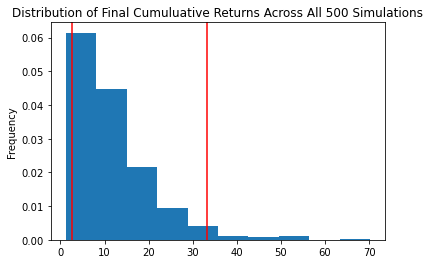

In [229]:
MC_n_years_new_allocation_original.plot_distribution()

In [230]:
MC_n_years_new_allocation_original.summarize_cumulative_return()

count           500.000000
mean             11.986082
std               8.958530
min               1.220931
25%               6.061233
50%               9.665468
75%              15.431826
max              70.227918
95% CI Lower      2.547019
95% CI Upper     33.201646
Name: 5040, dtype: float64

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 5040 Trading Days.'}>

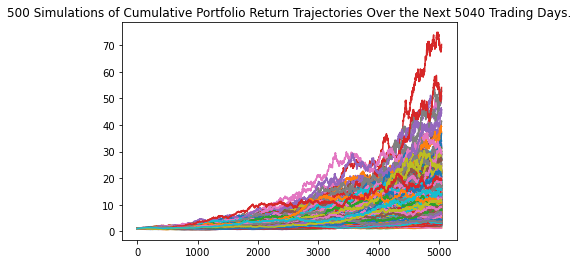

In [261]:
MC_n_years_new_allocation_original.plot_simulation()

In [336]:
# This was the first optimization - Not good example. It generates less return.
MC_n_years_optimized=MCSimulation(
    portfolio_data=all_results_df
    ,weights=list(optimal_portfolio_weights[1])
    ,num_simulation=500
    ,num_trading_days=252*int(report_df['years_until_retirement'][0])
)

In [337]:
MC_n_years_optimized.portfolio_data.head()

AGG                  CMG                 GOOG  \
                            close daily_return   close daily_return   close   
time                                                                          
2008-01-02 00:00:00-05:00  101.65          NaN  146.68          NaN  342.59   
2008-01-03 00:00:00-05:00  101.72     0.000689  141.46    -0.035588  342.49   
2008-01-04 00:00:00-05:00  102.12     0.003932  127.12    -0.101371  328.48   
2008-01-07 00:00:00-05:00  102.26     0.001371  123.61    -0.027612  324.34   
2008-01-08 00:00:00-05:00  102.51     0.002445  117.77    -0.047245  315.66   

                                           IBM                  SPY  \
                          daily_return   close daily_return   close   
time                                                                  
2008-01-02 00:00:00-05:00          NaN  104.79          NaN  144.55   
2008-01-03 00:00:00-05:00    -0.000292  104.94     0.001431  144.46   
2008-01-04 00:00:00-05:00    -0.040906  101.11    -0.036497  140.93   
2008-01-07 00:00:00-05:00    -0.012604  100.14    -0.009594  141.46   
2008-01-08 00:00:00-05:00    -0.026762   97.39    -0.027462  138.81   

                                          XLB               
                          daily_return  close daily_return  
time                                                        
2008-01-02 00:00:00-05:00          NaN  41.33          NaN  
2008-01-03 00:00:00-05:00    -0.000623  41.80     0.011372  
2008-01-04 00:00:00-05:00    -0.024436  40.74    -0.025359  
2008-01-07 00:00:00-05:00     0.003761  40.25    -0.012027  
2008-01-08 00:00:00-05:00    -0.018733  39.60    -0.016149

In [338]:
MC_n_years_optimized.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.025517,1.018287,1.005125,0.996623,0.998384,1.002574,1.005362,1.002059,1.009719,1.013932,...,0.980260,0.992793,1.000228,1.000109,0.998475,1.012447,0.994691,1.010466,1.008568,1.019209
2,1.032184,1.026471,1.005020,1.006903,0.998135,0.995923,1.001330,1.007342,1.012732,1.024809,...,0.967598,0.998124,0.981686,0.985825,1.009311,1.028136,0.983682,1.016987,1.016036,1.015648
3,1.046019,1.027013,1.027039,1.000004,0.991123,1.004414,0.991179,0.976451,1.017786,1.022256,...,0.969600,0.994692,0.986499,0.989554,0.994081,1.037203,0.992788,1.024606,1.031683,1.025281
4,1.033582,1.027475,1.047879,1.000738,1.000186,1.019524,0.997322,0.984421,1.007801,1.028782,...,0.966063,0.972067,1.011234,0.989623,1.003196,1.046472,0.992277,1.020423,1.026851,1.021193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,89.080789,30.916558,13.080554,134.822340,29.853876,21.049123,67.819473,22.204144,23.826102,16.333309,...,14.658720,12.435738,5.193022,42.855641,10.265479,17.604966,21.257720,21.470046,35.785565,31.988883
5037,90.210396,31.229898,13.213723,133.153786,29.430851,20.948869,68.238942,22.473242,23.797863,16.322693,...,14.943713,12.340819,5.220652,42.372712,10.255930,17.807496,21.434501,20.961513,35.541723,31.925923
5038,90.574362,31.262754,13.123382,133.960683,29.720842,21.310379,67.314951,21.936750,23.745895,16.287987,...,14.684772,12.174909,5.238951,41.840165,10.274989,17.824377,21.321986,21.150232,35.570196,31.916771
5039,89.679880,30.995088,13.001600,134.250517,29.918183,21.221401,66.196249,21.721963,23.867792,16.357667,...,14.505643,12.174885,5.270760,41.625326,10.140489,18.015157,21.494614,21.278985,35.472877,31.819739


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

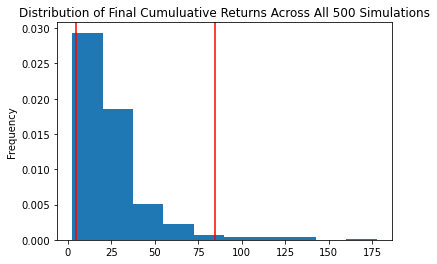

In [339]:
MC_n_years_optimized.plot_distribution() 

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 5040 Trading Days.'}>

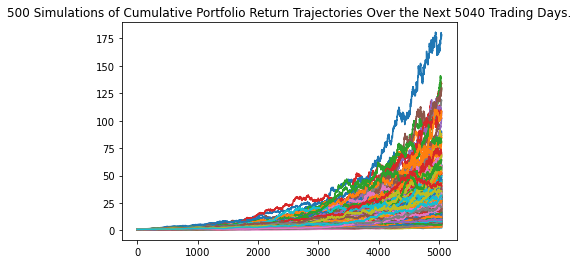

In [340]:
MC_n_years_optimized.plot_simulation()

In [341]:
MC_n_years_optimized.summarize_cumulative_return()
MC_n_years_optimized.summarize_cumulative_return()

count           500.000000
mean             24.848087
std              20.817210
min               2.421050
25%              12.182511
50%              19.304708
75%              30.431426
max             177.522991
95% CI Lower      4.465851
95% CI Upper     84.704659
Name: 5040, dtype: float64

In [342]:
#Summary statistics result comparison
summary_statistics_combined=pd.concat([MC_n_years_new_allocation_original.summarize_cumulative_return(),MC_n_years_optimized.summarize_cumulative_return()]
          , axis=1)

summary_statistics_combined.columns=["Original","Optimized"]
round(summary_statistics_combined ,2)    

,Original,Optimized
count,500.00,500.00
mean,11.99,24.85
std,8.96,20.82
min,1.22,2.42
25%,6.06,12.18
50%,9.67,19.30
75%,15.43,30.43
max,70.23,177.52
95% CI Lower,2.55,4.47
95% CI Upper,33.20,84.70


In [343]:
# Calculating expected future amount
initial_investment=50000
final_investment=summary_statistics_combined.iloc[1:10,:]*initial_investment

# Apply money 
final_investment['Original']=final_investment['Original'].apply(lambda x: "${:,.0f}k".format(x/1000))
final_investment['Optimized']=final_investment['Optimized'].apply(lambda x: "${:,.0f}k".format(x/1000))
final_investment

,Original,Optimized
mean,$599k,"$1,242k"
std,$448k,"$1,041k"
min,$61k,$121k
25%,$303k,$609k
50%,$483k,$965k
75%,$772k,"$1,522k"
max,"$3,511k","$8,876k"
95% CI Lower,$127k,$223k
95% CI Upper,"$1,660k","$4,235k"


# Future improvements: 
* Optimization: option to decrease variance, but keep original expected return.
* Montecarlo Simulation: include option for periodic contributions